In [2]:

import sys
sys.path.append('/Users/rafaelcurran/Documents/Development/CS_598_CCC/dl-env/lib/python3.12/site-packages')

from google.protobuf import descriptor as _descriptor
print("Protobuf import successful.")



Protobuf import successful.


In [24]:
import os
import time
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from io import BytesIO
import sys
from torchvision import transforms
import zlib
from utils import ImagePathDataset, custom_collate_fn


class DecodeJPEG:
    def __call__(self, raw_bytes):
        return Image.open(BytesIO(raw_bytes))
        
class ConditionalNormalize:
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean=mean, std=std)

    def __call__(self, tensor):
        # Only apply normalization if the tensor has 3 channels
        if tensor.shape[0] == 1:
            tensor = tensor.repeat(3, 1, 1)  # Repeat the single channel across the 3 RGB channels
        
        # Apply normalization to 3-channel (RGB) images
        return self.normalize(tensor)

        
def capture_transformation_sizes(dataset_path, batch_size=100):
    # Define transformations
    decode_jpeg = DecodeJPEG()
    transformations = [
        decode_jpeg,  # Decode raw JPEG bytes to a PIL image
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Converts PIL images to tensors
        ConditionalNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ]
    print("Starting to process the dataset...")
    dataset = ImagePathDataset(os.path.join(dataset_path, 'train'))
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=8, pin_memory=True, collate_fn=custom_collate_fn)
    
    size_data = {f"Stage_{i}": [] for i in range(len(transformations) + 1)}  # +1 to include raw size
    compressed_size_data = {f"Stage_{i}": [] for i in range(len(transformations) + 1)}  # Track compressed sizes
    processing_times = {f"Stage_{i}": [] for i in range(len(transformations) + 1)}  # Track processing times for each stage
    compression_processing_times = {f"Stage_{i}": [] for i in range(len(transformations) + 1)}  # Track processing times for each stage
    print("Starting to process the dataset...")
    # Process each image and capture sizes
    for batch_idx, (data, _) in enumerate(loader):
        for img_data in data:
            current_data = img_data
            # Raw image size
            raw_size = len(current_data)
            size_data["Stage_0"].append(raw_size)
            start_time = time.time()
            compressed_data = zlib.compress(current_data)
            elapsed_time = time.time() - start_time
            compression_processing_times["Stage_0"].append(elapsed_time)
            compressed_size_data["Stage_0"].append(len(compressed_data))
            processing_times["Stage_0"].append(0)
            

            # Apply each transformation in sequence
            for i, transform in enumerate(transformations, 1):
                # if isinstance(current_data, bytes):
                #     current_data = Image.open(BytesIO(current_data))
                
                start_time = time.time()
                current_data = transform(current_data)
                elapsed_time = time.time() - start_time
                processing_times[f"Stage_{i}"].append(elapsed_time)

                
               
                # Calculate the size after each transformation
                start_time = time.time()
                if isinstance(current_data, torch.Tensor):
                    data_size = current_data.nelement() * current_data.element_size()
                elif isinstance(current_data, np.ndarray):
                    data_size = current_data.nbytes
                elif isinstance(current_data, Image.Image):
                    data_size = len(current_data.tobytes())
                else:
                    data_size = sys.getsizeof(current_data)
                if isinstance(current_data, (torch.Tensor, np.ndarray)):
                    # Convert tensor or numpy array to bytes for compression
                    data_bytes = current_data.numpy().tobytes() if isinstance(current_data, torch.Tensor) else current_data.tobytes()
                    compressed_data = zlib.compress(data_bytes)
                elif isinstance(current_data, Image.Image):
                    # Convert PIL image to bytes for compression
                    img_byte_arr = BytesIO()
                    current_data.save(img_byte_arr, format='JPEG')
                    compressed_data = zlib.compress(img_byte_arr.getvalue())
                else:
                    compressed_data = zlib.compress(current_data)
                end_time = time.time()
                elapsed_time = time.time() - start_time
                compression_processing_times[f"Stage_{i}"].append(elapsed_time)

                compressed_size_data[f"Stage_{i}"].append(len(compressed_data))
                size_data[f"Stage_{i}"].append(data_size)
        if (batch_idx + 1) % 10 == 0:
            print(f"Completed {batch_idx + 1} batches")
        if batch_idx >= 1:  # Limit processing for demonstration, remove to process full dataset
            break

    return size_data, compressed_size_data, processing_times, compression_processing_times



In [26]:
dataset_path = 'imagenet'
size_data, compressed_size_data, processing_times, compression_processing_times = capture_transformation_sizes(dataset_path)

Starting to process the dataset...
Starting to process the dataset...


In [ ]:
def plot_boxplot(size_data, save_path="image_size_distribution.png"):
    # Define descriptive stage names for the transformations
    stage_names = [
        "Raw File",               # Stage 0
        "DecodeJPEG",             # Stage 1
        "RandomResizedCrop",      # Stage 2
        "RandomHorizontalFlip",   # Stage 3
        "ToTensor",               # Stage 4
        "ConditionalNormalize"    # Stage 5
    ]
    
    # Convert sizes from bytes to kilobytes
    stages = sorted(size_data.keys())
    data = [[size / 1024 for size in size_data[stage]] for stage in stages]
    
    # Plot box plots with descriptive stage names
    plt.figure(figsize=(12, 8))
    plt.boxplot(data, labels=stage_names, showfliers=False)
    plt.xlabel("Transformation Stage")
    plt.ylabel("Image Size (KB)")
    plt.title("Image Size Distribution at Each Transformation Stage")
    
    # Save the plot to the specified file path
    plt.savefig(save_path, format="png", dpi=300)
    print(f"Plot saved as {os.path.abspath(save_path)}")
    
    plt.show()

In [ ]:

plot_boxplot(compressed_size_data)

/var/folders/tk/9n3n95cj7q78qwx026z2x3zm0000gn/T/ipykernel_38882/1622588252.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_names, showfliers=False)


Plot saved as /Users/rafaelcurran/Documents/Development/CS_598_CCC/dl-processing-pipeline/training/image_size_distribution.png


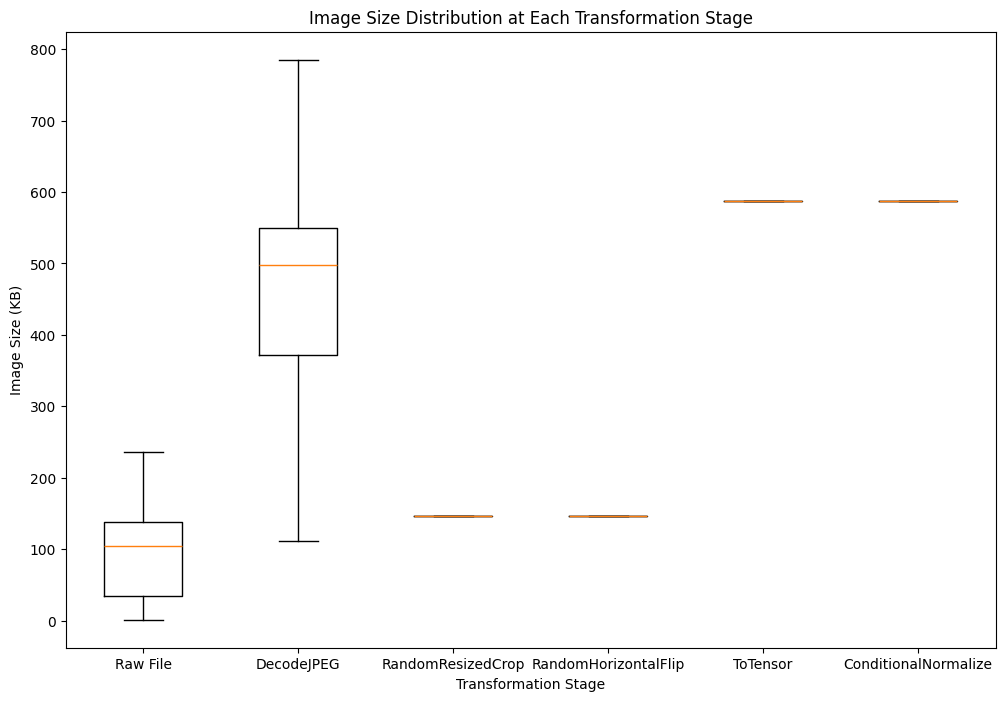

In [7]:
plot_boxplot(size_data)

In [ ]:
import matplotlib.pyplot as plt
import os

def plot_side_by_side_boxplots(size_data, compressed_size_data, save_path="image_size_distribution_comparison.png"):
    # Define descriptive stage names for the transformations, excluding "Raw File" for compressed data
    stage_names = [
        "Raw File",               # Stage 0
        "DecodeJPEG",             # Stage 1
        "RandomResizedCrop",      # Stage 2
        "RandomHorizontalFlip",   # Stage 3
        "ToTensor",               # Stage 4
        "ConditionalNormalize"    # Stage 5
    ]
    
    # Convert sizes from bytes to kilobytes
    stages = sorted(size_data.keys())
    size_data_kb = [[size / 1024 for size in size_data[stage]] for stage in stages]
    compressed_size_data_kb = [[size / 1024 for size in compressed_size_data[stage]] for stage in stages[1:]]  # Skip "Raw File" for compressed data
    
    # Create side-by-side box plots
    fig, ax = plt.subplots(figsize=(15, 8))
    num_stages = len(stage_names)
    box_width = 0.35  # Width for each box in the pair

    # Offset positions for size and compressed_size data for side-by-side arrangement
    positions_size = [i + 1 - box_width / 2 for i in range(num_stages)]
    positions_compressed = [i + 1 + box_width / 2 for i in range(1, num_stages)]  # Start compressed at DecodeJPEG
    
    # Plot the box plots
    bplot_size = ax.boxplot(size_data_kb, positions=positions_size, widths=box_width, patch_artist=True,
                            boxprops=dict(facecolor="lightblue"), medianprops=dict(color="blue"), showfliers=False)
    bplot_compressed = ax.boxplot(compressed_size_data_kb, positions=positions_compressed, widths=box_width, patch_artist=True,
                                  boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="red"), showfliers=False)

    # Customizing the plot
    ax.set_xticks(range(1, num_stages + 1))
    ax.set_xticklabels(stage_names)
    ax.set_xlabel("Transformation Stage")
    ax.set_ylabel("Image Size (KB)")
    ax.set_title("Comparison of Original and Compressed Image Sizes at Each Transformation Stage (Excluding Raw File for Compression)")
    ax.legend([bplot_size["boxes"][0], bplot_compressed["boxes"][0]], ["Original Size", "Compressed Size"], loc="upper right")

    # Save and display
    plt.savefig(save_path, format="png", dpi=300)
    print(f"Plot saved as {os.path.abspath(save_path)}")
    plt.show()



In [ ]:
plot_side_by_side_boxplots(size_data, compressed_size_data)

In [13]:
def find_mismatched_minimum_stage(size_data, compressed_size_data):
    mismatched_samples = []
    num_samples = len(next(iter(size_data.values())))  # Assuming all stages have the same number of samples
    
    # Adjust ranges to match actual stages in size_data and compressed_size_data
    size_data_stages = sorted(size_data.keys())
    compressed_size_data_stages = sorted(compressed_size_data.keys())
    
    for sample_idx in range(num_samples):
        # Find the stage where the minimum size is achieved in size_data
        min_stage_size = min(size_data_stages, key=lambda stage: size_data[stage][sample_idx])
        
        # Find the stage where the minimum size is achieved in compressed_size_data (excluding Stage_0)
        min_stage_compressed = min(compressed_size_data_stages, key=lambda stage: compressed_size_data[stage][sample_idx])
        
        # Check if the minimum stage differs between size_data and compressed_size_data
        if min_stage_size != min_stage_compressed:
            mismatched_samples.append({
                "sample_index": sample_idx,
                "size_data_min_stage": min_stage_size,
                "compressed_size_data_min_stage": min_stage_compressed
            })
    
    return mismatched_samples

# Example usage
mismatches = find_mismatched_minimum_stage(size_data, compressed_size_data)
print("Samples where minimum size stage differs between size_data and compressed_size_data:")
for mismatch in mismatches:
    print(mismatch)



Samples where minimum size stage differs between size_data and compressed_size_data:
{'sample_index': 0, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_1'}
{'sample_index': 2, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_2'}
{'sample_index': 4, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_2'}
{'sample_index': 5, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_1'}
{'sample_index': 6, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_1'}
{'sample_index': 7, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_2'}
{'sample_index': 8, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_3'}
{'sample_index': 10, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_3'}
{'sample_index': 11, 'size_data_min_stage': 'Stage_0', 'compressed_size_data_min_stage': 'Stage_2'}
{'sample_index': 13, '

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_minimum_size_stages(size_data, compressed_size_data):
    # Define descriptive stage names
    stage_names = [
        "Raw File",               # Stage 0
        "DecodeJPEG",             # Stage 1
        "RandomResizedCrop",      # Stage 2
        "RandomHorizontalFlip",   # Stage 3
        "ToTensor",               # Stage 4
        "ConditionalNormalize"    # Stage 5
    ]
    
    # Initialize counters for minimum occurrences for each stage
    size_data_min_counts = {i: 0 for i in range(len(stage_names))}
    compressed_size_data_min_counts = {i: 0 for i in range(len(stage_names))}  # Skip Stage 0 for compressed data

    # Find minimum stages for size_data
    for sample_idx in range(len(next(iter(size_data.values())))):
        min_stage_size = min(size_data.keys(), key=lambda stage: size_data[stage][sample_idx])
        stage_index = int(min_stage_size.split('_')[1])
        size_data_min_counts[stage_index] += 1

    # Find minimum stages for compressed_size_data (starting from Stage 1)
    for sample_idx in range(len(next(iter(compressed_size_data.values())))):
        min_stage_compressed = min(compressed_size_data.keys(), key=lambda stage: compressed_size_data[stage][sample_idx])
        stage_index = int(min_stage_compressed.split('_')[1])
        compressed_size_data_min_counts[stage_index] += 1

    # Prepare data for plotting by mapping counts to stage names
    stages = np.arange(len(stage_names))
    size_counts = [size_data_min_counts.get(i, 0) for i in range(len(stage_names))]
    compressed_counts = [compressed_size_data_min_counts.get(i, 0) for i in range(len(stage_names))]

    # Plot the bar chart
    bar_width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.bar(stages - bar_width / 2, size_counts, bar_width, label='Original Size', color='lightblue')
    ax.bar(stages + bar_width / 2, compressed_counts, bar_width, label='Compressed Size', color='lightcoral')
    
    # Customize the plot
    ax.set_xlabel("Transformation Stage")
    ax.set_ylabel("Number of Samples with Minimum Size")
    ax.set_title("Number of Samples Achieving Minimum Size at Each Transformation Stage")
    ax.set_xticks(stages)
    ax.set_xticklabels(stage_names, rotation=45)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


# Example usage
# plot_minimum_size_stages(size_data, compressed_size_data)


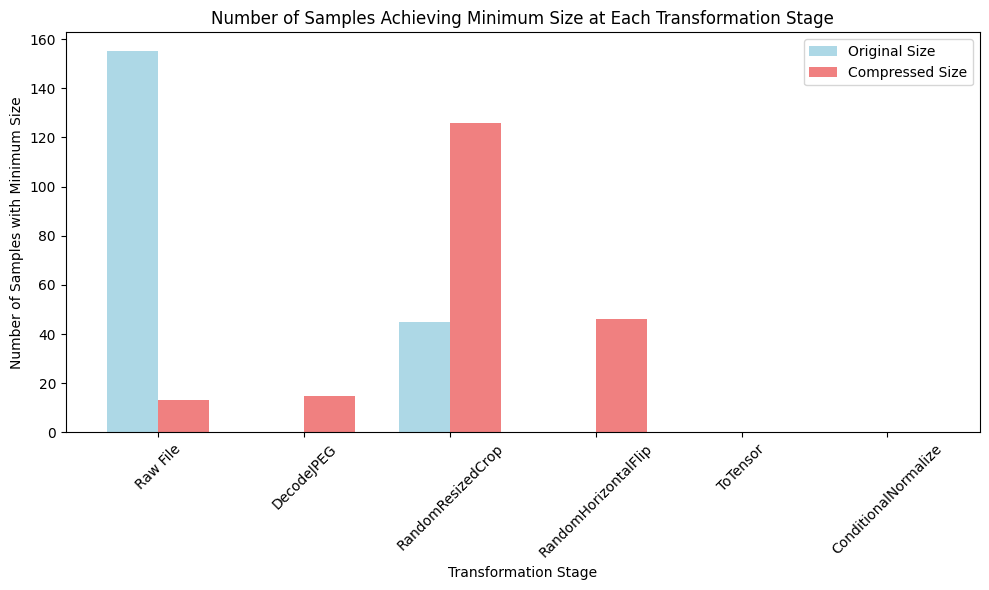

In [23]:
plot_minimum_size_stages(size_data, compressed_size_data)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import heapq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_offloading_plans(size_data, compressed_size_data, processing_times, compression_processing_times):
    offloading_heap = []
    num_samples = len(size_data["Stage_0"])

    # Iterate over each sample
    for sample_idx in range(num_samples):
        original_size = size_data["Stage_0"][sample_idx]

        # Calculate offloading efficiency without compression
        cumulative_time_no_compression = 0
        min_size_no_compression = float('inf')
        best_stage_no_compression = None

        for i in range(1, len(size_data)):
            current_size = size_data[f"Stage_{i}"][sample_idx]
            cumulative_time_no_compression += processing_times[f"Stage_{i}"][sample_idx]
            
            if current_size < min_size_no_compression:
                min_size_no_compression = current_size
                best_stage_no_compression = i

        if cumulative_time_no_compression > 0 and min_size_no_compression < original_size:
            efficiency_no_compression = (original_size / min_size_no_compression) / cumulative_time_no_compression
            size_reduction_no_compression = original_size / min_size_no_compression
        else:
            efficiency_no_compression = 0

        # Calculate offloading efficiency with compression
        cumulative_time_with_compression = 0
        min_size_with_compression = float('inf')
        best_stage_with_compression = None

        for i in range(1, len(compressed_size_data)):
            current_compressed_size = compressed_size_data[f"Stage_{i}"][sample_idx]
            cumulative_time_with_compression += processing_times[f"Stage_{i}"][sample_idx]
            
            if current_compressed_size < min_size_with_compression:
                min_size_with_compression = current_compressed_size
                best_stage_with_compression = i
                min_cumulative_time_with_compression = cumulative_time_with_compression + compression_processing_times[f"Stage_{i}"][sample_idx]

        if min_cumulative_time_with_compression > 0 and min_size_with_compression < original_size:
            efficiency_with_compression = (original_size / min_size_with_compression) / min_cumulative_time_with_compression
            size_reduction_with_compression = original_size / min_size_with_compression
        else:
            efficiency_with_compression = 0

        # Select the best offloading plan
        if efficiency_no_compression > efficiency_with_compression:
            if efficiency_no_compression > 0:
                # Insert plan without compression
                heapq.heappush(offloading_heap, (-efficiency_no_compression, (
                    sample_idx, size_reduction_no_compression, cumulative_time_no_compression, 
                    best_stage_no_compression, False)))
        elif efficiency_with_compression > 0:
            # Insert plan with compression
            heapq.heappush(offloading_heap, (-efficiency_with_compression, (
                sample_idx, size_reduction_with_compression, min_cumulative_time_with_compression, 
                best_stage_with_compression, True)))

    return offloading_heap

def plot_offloading_efficiency_distribution(offloading_heap):
    # Extract efficiencies from the heap for plotting
    efficiencies = [-entry[0] for entry in offloading_heap]
    compression_labels = ["With Compression" if entry[1][4] else "Without Compression" for entry in offloading_heap]

    # Density plot of offloading efficiencies with separate colors for compression and no compression
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        [eff for eff, label in zip(efficiencies, compression_labels) if label == "Without Compression"],
        color="skyblue", fill=True, label="Without Compression"
    )
    sns.kdeplot(
        [eff for eff, label in zip(efficiencies, compression_labels) if label == "With Compression"],
        color="salmon", fill=True, label="With Compression"
    )
    plt.xlabel("Offloading Efficiency")
    plt.ylabel("Density")
    plt.title("Density Plot of Offloading Efficiencies (With and Without Compression)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# offloading_heap = generate_offloading_plans(size_data, compressed_size_data, processing_times, compression_processing_times)
# plot_offloading_efficiency_distribution(offloading_heap)


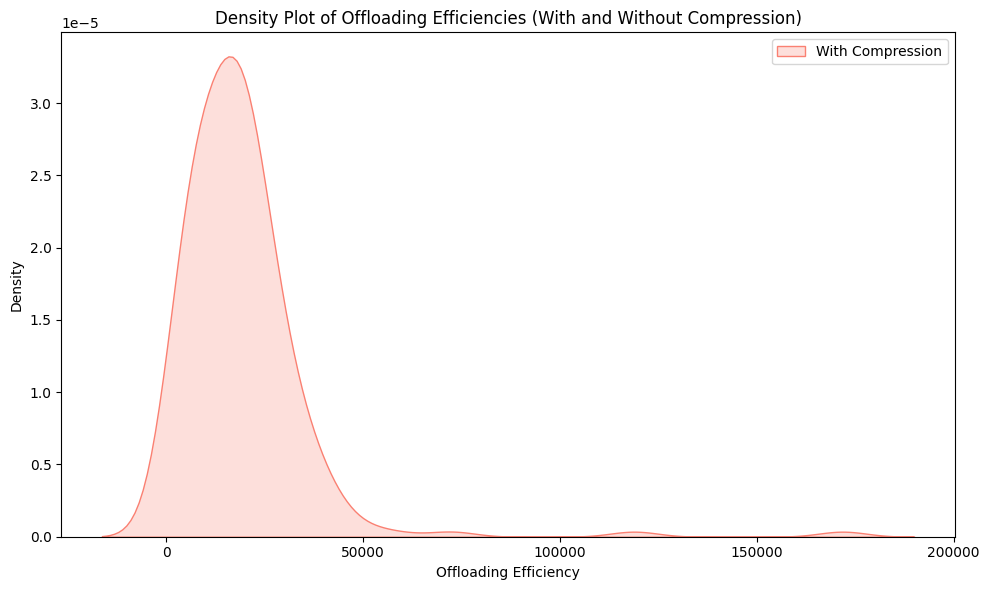

In [39]:
offloading_heap = generate_offloading_plans(size_data, compressed_size_data, processing_times, compression_processing_times)
plot_offloading_efficiency_distribution(offloading_heap)

In [44]:
print(len(offloading_heap))

188
